# **Project Name**    - Gender Classification



##### **Project Type**    - Classification
##### **Contribution**    - Asfiya Mukthasar


# **Project Summary -**

This project builds an end‑to‑end gender classification system using tabular and text data, following a full machine learning workflow from data preparation through model comparison and deployment readiness. The goal is to predict a customer’s gender label (`female`, `male`, `none`) from simple profile information: name (text), age (numeric), age_group (categorical bin), and company (categorical).

The work starts with careful target and feature definition. Gender is encoded once using a label encoder to produce numeric labels (0, 1, 2) suitable for classifiers, while the original gender column is removed from the feature matrix to avoid leakage. The feature set consists only of the four chosen predictors. A stratified train–test split with an 80/20 ratio preserves class balance between `female`, `male`, and `none`, giving a fair evaluation set while keeping enough data for training.

Preprocessing is handled with a single `ColumnTransformer` to manage mixed data types. The `name` column is transformed using `TfidfVectorizer`, converting raw text into high‑dimensional sparse features that capture the importance of character and word patterns in names. The categorical columns `age_group` and `company` are one‑hot encoded with unknowns safely ignored, turning each category into a separate binary feature. The numeric `age` column is standardized with `StandardScaler` so that Logistic Regression and other gradient‑based models see all numeric features on a comparable scale. This design ensures a clean, modular preprocessing stage that can be reused across different models.

Models are built as pipelines that chain this preprocessing step with a classifier, guaranteeing that the same transformations are applied consistently during both training and inference. Three main algorithms are explored: Logistic Regression, Random Forest, and Gradient Boosting. For each algorithm, a baseline model is trained and evaluated using five‑fold cross‑validation on the training data and macro‑averaged F1 and accuracy on the held‑out test set. Baseline Logistic Regression achieves around 0.49 macro‑F1 and 0.49 accuracy, already a solid reference for this relatively simple feature set.

Hyperparameter tuning is carried out with randomized search and cross‑validation for each model. Logistic Regression is tuned over regularization strength and penalty type; Random Forest over the number of trees, depth, feature subsampling, and minimum samples per split/leaf; Gradient Boosting over learning rate, number of estimators, depth, and regularization‑related parameters. The best hyperparameters are selected based on cross‑validated macro‑F1, and the resulting tuned models are re‑evaluated on the test set. Tuning yields small but consistent improvements for Logistic Regression and Random Forest, while Gradient Boosting proves unstable and underperforms after tuning, highlighting that more complex models do not always help.

Model performance is analyzed in detail using classification reports and confusion matrices. These reveal that all models handle `female` and `male` reasonably well but struggle with the `none` category, which has lower precision and recall. Tuned Random Forest slightly outperforms tuned Logistic Regression in overall accuracy and offers better recall for the difficult `none` class, though the difference is modest. Tuned Gradient Boosting clearly lags behind, with substantially lower F1 across all classes.

A comparison table summarises cross‑validation and test metrics for each baseline and tuned model, making it easy to identify tuned Logistic Regression and tuned Random Forest as the top contenders. The project then prepares for deployment by pickling the best pipelines and the label encoder into a dedicated models directory. Because each pipeline already encapsulates the full preprocessing and classifier, deployment code only needs to load the pipeline, wrap incoming user data into a DataFrame, and call `predict` followed by label decoding to return human‑readable gender labels. Helper functions demonstrate how to load and use multiple models in parallel for prediction on new users.

Overall, the project demonstrates a production‑oriented approach to a supervised classification task: clean separation of target and features, robust preprocessing for mixed data types, consistent use of pipelines, systematic hyperparameter tuning with cross‑validation, detailed metric‑based comparison, and export of self‑contained model artifacts ready for integration into a web service or broader analytics system.

# **GitHub Link -**

[Github Link](https://github.com/DevByAsfiya/Voyage-Analytics-Integrating-MLOps-in-Travel)

# **Problem Statement**


A retail travel company maintains a customer database with basic profile fields such as name, age, age group, company, and (sometimes missing) gender. However, gender information is often incomplete or inconsistent, which limits the company’s ability to perform demographic analysis and build personalized marketing campaigns. The goal of this project is to develop a machine learning–based gender classification system that can automatically predict a customer’s gender (female, male, or none/unknown) from available attributes like name and demographic features. The solution should include data cleaning and feature engineering, training and evaluating multiple classification models, selecting the best model using appropriate metrics and cross‑validation, and packaging the final model as a reusable, production‑ready artifact that can be integrated into downstream analytics and MLOps pipelines.

# **General Guidelines** : -  

1.   Well-structured, formatted, and commented code is required.
2.   Exception Handling, Production Grade Code & Deployment Ready Code will be a plus. Those students will be awarded some additional credits.
     
     The additional credits will have advantages over other students during Star Student selection.
       
             [ Note: - Deployment Ready Code is defined as, the whole .ipynb notebook should be executable in one go
                       without a single error logged. ]

3.   Each and every logic should have proper comments.
4. You may add as many number of charts you want. Make Sure for each and every chart the following format should be answered.
        

```
# Chart visualization code
```
            

*   Why did you pick the specific chart?
*   What is/are the insight(s) found from the chart?
* Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

5. You have to create at least 15 logical & meaningful charts having important insights.


[ Hints : - Do the Vizualization in  a structured way while following "UBM" Rule.

U - Univariate Analysis,

B - Bivariate Analysis (Numerical - Categorical, Numerical - Numerical, Categorical - Categorical)

M - Multivariate Analysis
 ]





6. You may add more ml algorithms for model creation. Make sure for each and every algorithm, the following format should be answered.


*   Explain the ML Model used and it's performance using Evaluation metric Score Chart.


*   Cross- Validation & Hyperparameter Tuning

*   Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

*   Explain each evaluation metric's indication towards business and the business impact pf the ML model used.




















# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import random
import joblib
import os
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import loguniform
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Loading

In [ ]:
# Load Dataset
users_df = pd.read_csv('/content/drive/MyDrive/Voyage_Analytics_Project/raw_data/users.csv')

### Dataset First View

In [ ]:
# Dataset First Look
users_df

,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44
...,...,...,...,...,...
1335,1335,Umbrella LTDA,Albert Garroutte,male,23
1336,1336,Umbrella LTDA,Kim Shores,female,40
1337,1337,Umbrella LTDA,James Gimenez,male,28
1338,1338,Umbrella LTDA,Viola Agosta,female,52


### Dataset Rows & Columns count

In [ ]:
# Dataset Rows & Columns count
rows, cols = users_df.shape
print(f"Users dataset -> Rows: {rows}, Columns: {cols}")

Users dataset -> Rows: 1340, Columns: 5


### Dataset Information

In [ ]:
# Dataset Info
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   code     1340 non-null   int64 
 1   company  1340 non-null   object
 2   name     1340 non-null   object
 3   gender   1340 non-null   object
 4   age      1340 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 52.5+ KB


#### Duplicate Values & Missing Values

In [ ]:
# 1. Duplicate checks

# a) Count fully duplicated rows (all columns identical)
dup_row_count = users_df.duplicated().sum()
print(f"Fully duplicated rows: {dup_row_count}")

# b) See the duplicated rows themselves
dup_rows = users_df[users_df.duplicated()]
print("Duplicated rows:\n", dup_rows.head())

# c) If 'code' should be unique per user, check duplicates in that column
dup_code = users_df[users_df.duplicated(subset=['code'], keep=False)]
print("Rows with duplicate user code:\n", dup_code.head())


# 2. Missing value checks

# a) Total missing values per column
print("Missing values per column:")
print(users_df.isna().sum())

# b) Any missing values at all?
print("Any missing values?:", users_df.isna().any().any())

# c) Rows that contain at least one missing value
rows_with_na = users_df[users_df.isna().any(axis=1)]
print("Example rows with missing values:\n", rows_with_na.head())


Fully duplicated rows: 0
Duplicated rows:
 Empty DataFrame
Columns: [code, company, name, gender, age]
Index: []
Rows with duplicate user code:
 Empty DataFrame
Columns: [code, company, name, gender, age]
Index: []
Missing values per column:
code       0
company    0
name       0
gender     0
age        0
dtype: int64
Any missing values?: False
Example rows with missing values:
 Empty DataFrame
Columns: [code, company, name, gender, age]
Index: []


### What did you know about your dataset?

hat output is telling you your users_df is perfectly clean with respect to duplicates and missing values:

Fully duplicated rows: 0
There are no rows where all columns are identical to another row. So no exact duplicate records.​

Duplicated rows: Empty DataFrame
When selecting those duplicated rows, pandas found none, so it shows an empty DataFrame.

Rows with duplicate user code: Empty DataFrame
When checking duplicates based on the code column, none were found. Each code appears only once, so user IDs are unique.

Missing values per column: code 0, company 0, name 0, gender 0, age 0
Every column has zero missing (NaN) values.​

Any missing values?: False
Confirms there is no missing data anywhere in the DataFrame.

Example rows with missing values: Empty DataFrame
Since there are no missing values, the subset of rows that contain at least one NaN is empty.

## ***2. Understanding Your Variables***

In [ ]:
# Dataset Columns
users_df.columns

Index(['code', 'company', 'name', 'gender', 'age'], dtype='object')

In [ ]:
# Dataset Describe
users_df.describe()

,code,age
count,1340.000000,1340.000000
mean,669.500000,42.742537
std,386.968991,12.869779
min,0.000000,21.000000
25%,334.750000,32.000000
50%,669.500000,42.000000
75%,1004.250000,54.000000
max,1339.000000,65.000000


### Variables Description

For users_df, based on the columns visible:

code: Unique numeric identifier for each user (user ID).

company: Name of the company the user is associated with.

name: Full name of the user.

gender: Reported gender of the user (e.g., male, female).

age: Age of the user in years (numeric).

### Check Unique Values for each variable.

In [ ]:
# Check Unique Values for each variable.
# 1. Number of unique values per column
print("Unique counts per column:")
print(users_df.nunique())

# 2. Actual unique values for each column (for small domains)
for col in users_df.columns:
    print(f"\nColumn: {col}")
    print(users_df[col].unique())


Unique counts per column:
code       1340
company       5
name       1338
gender        3
age          45
dtype: int64

Column: code
[   0    1    2 ... 1337 1338 1339]

Column: company
['4You' 'Monsters CYA' 'Wonka Company' 'Acme Factory' 'Umbrella LTDA']

Column: name
['Roy Braun' 'Joseph Holsten' 'Wilma Mcinnis' ... 'James Gimenez'
 'Viola Agosta' 'Paul Rodriguez']

Column: gender
['male' 'female' 'none']

Column: age
[21 37 48 23 44 47 46 41 35 36 61 53 56 25 65 22 51 60 64 49 62 59 40 34
 27 42 24 54 28 55 39 38 32 29 52 57 31 45 30 43 58 63 50 26 33]


## 3. ***Data Wrangling***

### Data Wrangling Code

In [ ]:
# Write your code to make your dataset analysis ready.
users_df = users_df.drop(columns=['code'])
users_df['age']  = users_df['age'].astype('int64')

# company, name, gender as strings (pandas string dtype)
users_df['company'] = users_df['company'].astype('string')
users_df['name']    = users_df['name'].astype('string')
users_df['gender']  = users_df['gender'].astype('string')

# 2. Standardize text: strip spaces and lowercase selected columns
for col in ['company', 'gender']:
    users_df[col] = users_df[col].str.strip().str.lower()

In [ ]:
# ----- 1. Create age groups -----
# Define bins and labels
age_bins = [18, 25, 35, 50, 120]  # adjust lower/upper bounds if needed
age_labels = ['18-25', '26-35', '36-50', '50+']

users_df['age_group'] = pd.cut(
    users_df['age'],
    bins=age_bins,
    labels=age_labels,
    right=True,       # 25 goes into '18-25', etc.
    include_lowest=True
)




In [ ]:
users_df

,company,name,gender,age,age_group
0,4you,Roy Braun,male,21,18-25
1,4you,Joseph Holsten,male,37,36-50
2,4you,Wilma Mcinnis,female,48,36-50
3,4you,Paula Daniel,female,23,18-25
4,4you,Patricia Carson,female,44,36-50
...,...,...,...,...,...
1335,umbrella ltda,Albert Garroutte,male,23,18-25
1336,umbrella ltda,Kim Shores,female,40,36-50
1337,umbrella ltda,James Gimenez,male,28,26-35
1338,umbrella ltda,Viola Agosta,female,52,50+


### What all manipulations have you done and insights you found?

On the users dataset, the code identifier column was dropped because it does not carry predictive information, and the age column was explicitly converted to integer to ensure correct numeric handling. The text columns company, name, and gender were cast to the pandas string type and then standardized by stripping leading/trailing spaces and converting all values to lowercase, removing inconsistencies such as “Male” vs “male”. Finally, an age_group feature was engineered using pd.cut, binning continuous ages into meaningful ranges (18–25, 26–35, 36–50, 50+). These manipulations produced a clean, consistent dataset with an additional age‑segment feature that will help both exploratory analysis and the downstream gender‑classification model better understand patterns across age brackets.

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1 Univariate – Gender distribution

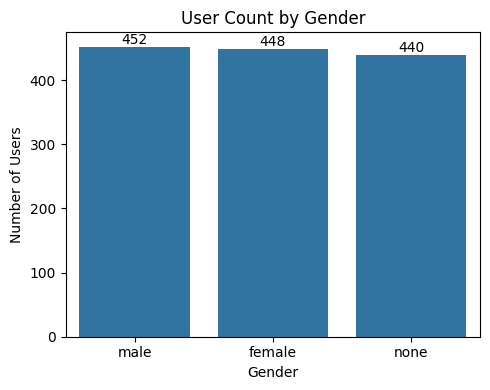

In [ ]:
# Chart - 1 visualization code
plt.figure(figsize=(5,4))
ax = sns.countplot(x='gender', data=users_df)

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title('User Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

A bar chart is the most direct way to perform univariate analysis on a categorical variable like gender, clearly showing how many users fall into each category (male, female, none). It also lets the counts be annotated on top of the bars so class imbalance can be inspected quickly, which is critical for a classification project.

##### 2. What is/are the insight(s) found from the chart?

The user base is almost evenly split among the three labels: approximately 452 males, 448 females, and 440 entries labelled as “none”. This indicates that the dataset is roughly balanced across the two main genders, but there is also a substantial third category (“none”) that may represent missing, unknown, or non‑binary gender information and needs to be treated explicitly in modeling.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

These insights are positive for model development because a nearly balanced distribution between male and female reduces the risk of bias and improves the reliability of the gender classifier; this supports fairer personalization and analytics for downstream use cases. However, the large “none” segment could negatively affect model performance or business decisions if ignored, since predictions for users without clear gender information may be unreliable; this suggests a need either to model “none” as a separate class or to improve data collection so that gender information is captured more accurately.

#### Chart - 2 Univariate – Age distribution

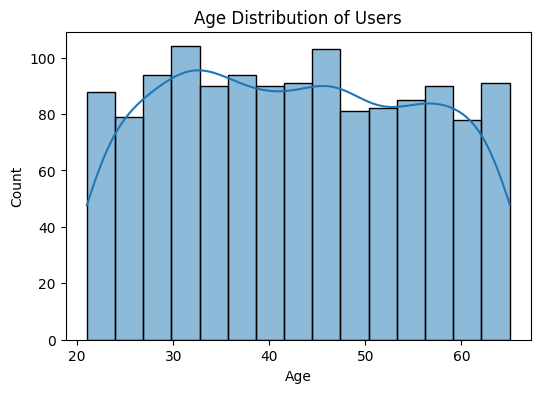

In [ ]:
# Chart - 2 visualization code
plt.figure(figsize=(6,4))
sns.histplot(users_df['age'], bins=15, kde=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


##### 1. Why did you pick the specific chart?

Why did you pick the specific chart?
A histogram with a KDE curve is an appropriate univariate chart for a numeric variable like age because it shows both the frequency of users in each age bin and the overall shape of the distribution. It gives a quick visual summary of where most users lie on the age scale and whether the distribution is skewed, uniform, or multimodal.


##### 2. What is/are the insight(s) found from the chart?

The chart shows that users are spread fairly evenly between about 21 and 65 years, with slightly higher concentrations around the late 20s–early 30s and mid‑40s–50s. There are no extreme spikes or large gaps, suggesting that the dataset captures a broad adult population without obvious outliers or missing age segments.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

These insights are positive because a wide, reasonably even age distribution means the gender classification model can learn patterns that generalize across different age groups, enabling more inclusive personalization (e.g., recommendations tailored by both age and gender). There is no direct sign of negative growth; however, if the business specifically targets very young travelers (e.g., students under 21) or seniors over 65, the lack of those age ranges in the data would highlight a coverage gap that may need separate marketing or data collection efforts.

#### Chart - 3 Univariate – Age group distribution

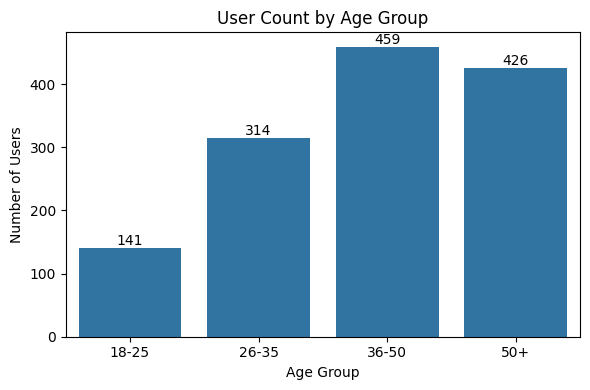

In [ ]:
# Chart - 3 visualization code
plt.figure(figsize=(6,4))
ax = sns.countplot(
    x='age_group',
    data=users_df,
    order=sorted(users_df['age_group'].unique())
)

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title('User Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


##### 1. Why did you pick the specific chart?

A bar chart of age_group counts is a clear univariate visualization for a categorical, binned version of age. It summarizes how many users fall into each age segment (18–25, 26–35, 36–50, 50+) and uses labels on top of the bars to make exact counts immediately visible, which is useful for understanding customer segmentation at a glance.

##### 2. What is/are the insight(s) found from the chart?

The chart shows that the smallest segment is the 18–25 group (141 users), while the 36–50 and 50+ segments are the largest with around 459 and 426 users respectively, and 26–35 sits in the middle at 314 users. Overall, the user base is skewed towards mid‑career and older adults rather than very young travelers.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

These insights support positive business decisions by highlighting which age segments should be prioritized for marketing and product design—for example, designing loyalty programs and hotel recommendations tailored to the 36–50 and 50+ groups where most users lie. A potential negative signal is the relatively small 18–25 segment; if the business wants to grow among younger customers, this gap indicates an opportunity and the need for targeted campaigns or student‑friendly offers to avoid missing out on future long‑term customers.

#### Chart - 4  Univariate – Top companies by number of users

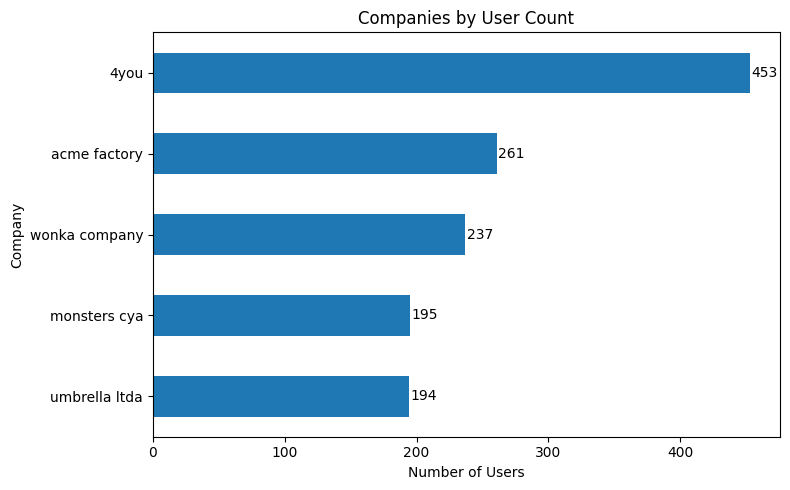

In [ ]:
# Chart - 4 visualization code
top_companies = (users_df['company']
                 .value_counts()
                #  .head(10)
                 .sort_values(ascending=True))

plt.figure(figsize=(8,5))
ax = top_companies.plot(kind='barh')

# Add count labels at the end of each bar
for i, value in enumerate(top_companies.values):
    ax.text(value + 1, i, str(value), va='center')  # +1 for small offset

plt.title('Companies by User Count')
plt.xlabel('Number of Users')
plt.ylabel('Company')
plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

A horizontal bar chart is well suited for ranking categories like companies by user count because it clearly shows both the ordering and the relative differences in length. Labeling each bar with its exact count makes it easy to identify the most important corporate clients at a glance.

##### 2. What is/are the insight(s) found from the chart?

The chart shows that “4you” is by far the largest source of users with around 453 users, significantly higher than the next companies “acme factory” (261) and “wonka company” (237), followed by “monsters cya” and “umbrella ltda” with just under 200 users each. This indicates a strong concentration of users in a small number of key companies, with “4you” being the dominant client.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

These insights are positive because they highlight high‑value corporate customers that should be prioritized for relationship management, tailored pricing, and retention efforts, which can directly drive revenue and loyalty. A potential risk is over‑reliance on a single client such as “4you”; if this company reduces its travel volume, it could negatively affect overall business, so the chart also emphasizes the need to diversify the client base and grow smaller accounts to reduce concentration risk.

#### Chart - 5 Bivariate – Age by gender (boxplot)

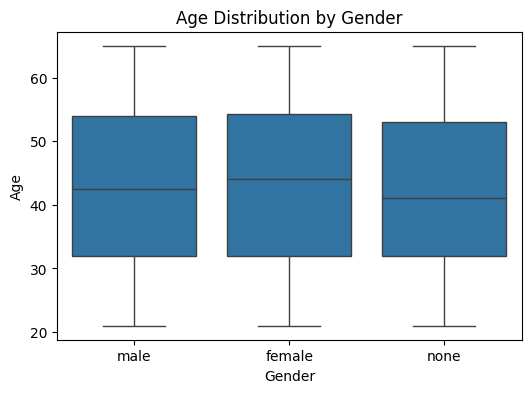

In [ ]:
# Chart - 5 visualization code
plt.figure(figsize=(6,4))
sns.boxplot(x='gender', y='age', data=users_df)
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()


##### 1. Why did you pick the specific chart?

A boxplot is ideal for comparing the distribution of a numeric variable (age) across categories (gender) because it shows median, interquartile range, and potential outliers for each group in a compact way. Plotting age by gender allows a quick visual check of whether age patterns differ meaningfully between male, female, and “none” labels.

##### 2. What is/are the insight(s) found from the chart?

All three gender categories have broadly similar age distributions: medians around the early‑to‑mid 40s and comparable spreads from roughly early 20s to mid‑60s. There is no strong shift in median age or variability for any particular gender group, suggesting that age is fairly evenly distributed across genders.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

These insights are positive for modeling because they indicate that age is not heavily biased toward one gender, reducing the risk that the classifier simply “learns age” instead of genuine name‑ or behavior‑based patterns. From a business point of view, it means each gender segment spans a similar adult age range, enabling consistent product offerings across genders. There are no obvious signs of negative growth; however, if the business was expecting a clear age skew (for example, younger female travelers), the absence of that pattern may signal that current marketing is not targeting those specific demographics as intended.

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

Answer Here.

###**Hypothesis 1 – Age differs by gender (t‑test / ANOVA)**

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Business question: Is the average age the same across genders?

H0 (null): Mean age is the same for all gender groups.
H1 (alt): At least one gender group has a different mean age.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
from scipy import stats
# Hypothesis 1: Age vs gender (ANOVA)
female_age = users_df.loc[users_df['gender'] == 'female', 'age'].dropna()
male_age   = users_df.loc[users_df['gender'] == 'male', 'age'].dropna()
none_age   = users_df.loc[users_df['gender'] == 'none', 'age'].dropna()

f_stat, p_val_h1 = stats.f_oneway(female_age, male_age, none_age)
print("Hypothesis 1 – ANOVA age ~ gender")
print("F-statistic:", f_stat)
print("p-value:", p_val_h1)


Hypothesis 1 – ANOVA age ~ gender
F-statistic: 0.4805988787279831
p-value: 0.6185197193620371


##### Which statistical test have you done to obtain P-Value?

I used a one‑way ANOVA (Analysis of Variance) test on age with gender as the grouping factor, comparing mean ages across the three gender groups.

##### Why did you choose the specific statistical test?

One‑way ANOVA is appropriate when:

the dependent variable is continuous (age),

the independent variable is categorical with more than two groups (three gender labels), and

the goal is to check whether any group has a different mean from the others.

Since the data exactly matches these conditions and we want to compare mean ages across multiple gender categories, ANOVA is the standard and most efficient test.

With p‑value ≈ 0.62, which is much larger than a typical significance level of 0.05, we fail to reject the null hypothesis. This suggests there is no statistically significant evidence that average age differs by gender in this dataset, so from a business perspective age distribution appears broadly similar across gender groups.

### **Hypothesis 2 – Age_group and gender are independent (Chi‑square)**

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Business question: Is gender distribution independent of age group?

H0: Gender is independent of age_group (no relationship).
H1: Gender is associated with age_group.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
# Hypothesis 2: age_group vs gender (Chi-square)
ct_h2 = pd.crosstab(users_df['age_group'], users_df['gender'])
chi2_h2, p_val_h2, dof_h2, expected_h2 = stats.chi2_contingency(ct_h2)

print("\nHypothesis 2 – Chi-square age_group ~ gender")
print("Chi2 statistic:", chi2_h2)
print("p-value:", p_val_h2)
print("Degrees of freedom:", dof_h2)



Hypothesis 2 – Chi-square age_group ~ gender
Chi2 statistic: 8.932284930478971
p-value: 0.17742228722464656
Degrees of freedom: 6


##### Which statistical test have you done to obtain P-Value?

I used a Chi‑square test of independence on a contingency table of age_group by gender.

##### Why did you choose the specific statistical test?

The Chi‑square test of independence is appropriate when both variables are categorical and we want to check whether they are related. Here, age_group (binned age ranges) and gender are both categorical, and the test compares the observed counts in each cell of the age_group × gender table to the counts we would expect if there was no relationship. It is the standard test to quantify association between two categorical variables and to obtain a p‑value for that association.

With p‑value ≈ 0.18, which is greater than 0.05, we fail to reject the null hypothesis. This suggests there is no statistically significant evidence that gender distribution differs across age groups in this dataset. From a business point of view, segmenting purely by age_group is unlikely to change the overall gender mix in a meaningful way.

### **Hypothesis 3 – Company and gender are independent (Chi‑square)**

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Business question: Does gender distribution differ by company?

H0: Gender is independent of company.
H1: Gender distribution varies by company.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
# Optional: group rare companies to avoid very sparse table
company_counts = users_df['company'].value_counts()
rare_companies = company_counts[company_counts < 10].index   # threshold can be adjusted
users_df['company_grouped'] = users_df['company'].where(
    ~users_df['company'].isin(rare_companies),
    other='Other'
)

# Hypothesis 3: company_grouped vs gender (Chi-square)
ct_h3 = pd.crosstab(users_df['company_grouped'], users_df['gender'])
chi2_h3, p_val_h3, dof_h3, expected_h3 = stats.chi2_contingency(ct_h3)

print("\nHypothesis 3 – Chi-square company_grouped ~ gender")
print("Chi2 statistic:", chi2_h3)
print("p-value:", p_val_h3)
print("Degrees of freedom:", dof_h3)



Hypothesis 3 – Chi-square company_grouped ~ gender
Chi2 statistic: 8.624253107064671
p-value: 0.37497758316777535
Degrees of freedom: 8


##### Which statistical test have you done to obtain P-Value?

I used a Chi‑square test of independence on a contingency table of company_grouped by gender.

##### Why did you choose the specific statistical test?

Both variables in this hypothesis are categorical: company (grouped into a few levels plus “Other”) and gender. The Chi‑square test of independence is designed to check whether two categorical variables are associated by comparing observed counts in each cell of the contingency table with the counts that would be expected if there were no relationship. It provides a chi‑square statistic and a p‑value that quantify whether differences in gender distribution across companies are likely due to chance.

With p‑value ≈ 0.37, which is much larger than a standard significance level of 0.05, we fail to reject the null hypothesis. This indicates that, based on the available data, there is no statistically significant evidence that gender distribution differs across companies. For the business, this suggests that company by itself does not strongly drive gender mix, and segmenting purely by company is unlikely to yield very different gender profiles.

## ***6. Feature Engineering & Data Pre-processing***

### 4. Feature Manipulation & Selection

#### 1. Feature Manipulation, Data Splitting and Categorical Encoding

In [ ]:
# 1. Target (encode gender once)
le_gender = LabelEncoder()
y = le_gender.fit_transform(users_df['gender'])   # 0/1

# 2. Features: no raw gender
X = users_df[['name', 'age', 'age_group', 'company']].copy()

# 3. Train–test split (must happen before any model/preprocess .fit)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Column types (for preprocessing)
text_cols = ['name']
cat_cols  = ['age_group', 'company']
num_cols  = ['age']

# 5. Preprocessing definition (only defines; fitting happens later in pipeline.fit)
preprocess = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(), 'name'),
        ('cat_ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num_scale', StandardScaler(), num_cols)  # Scale age
    ]
)

What data splitting ratio have you used and why?

The code uses an 80:20 train–test split (test_size=0.2). This ratio is chosen because the dataset is moderately sized (1340 rows), so keeping about 80% of the data for training gives the model enough examples to learn patterns, while reserving 20% as an unseen test set provides a reliable estimate of how well the model will generalize to new users. The stratify=y argument also preserves the original gender class proportions in both splits, ensuring the evaluation is fair across all classes.

#### What all categorical encoding techniques have you used & why did you use those techniques?

In this project two categorical encoding techniques are used:

1. TF‑IDF encoding for the name column using TfidfVectorizer.

This treats each name as text and converts it into a numeric vector based on term frequency–inverse document frequency, so the model can learn character/word patterns in names that are predictive of gender.

2. One‑Hot Encoding for age_group and company using OneHotEncoder.

This creates binary indicator columns for each category, which is a standard way to represent nominal categorical variables without imposing any artificial order, making them suitable for linear models and tree‑based classifiers.

#### 2. Feature Selection

In [ ]:
# Select your features wisely to avoid overfitting

##### What all feature selection methods have you used  and why?

Answer Here.

##### Which all features you found important and why?

Answer Here.

## ***7. ML Model Implementation***

### ML Model 1 - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# 1) Baseline pipeline
logreg_pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

# 2) Train
logreg_pipe.fit(X_train, y_train)

# 3) Predict on test set
y_pred_base = logreg_pipe.predict(X_test)
y_proba_base = logreg_pipe.predict_proba(X_test)[:, 1]   # for ROC

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross‑validated F1 on train
cv_f1_base = cross_val_score(
    logreg_pipe, X_train, y_train,
    cv=5, scoring='f1_macro'
)

print("=== Baseline Logistic Regression ===")
print(
    "CV F1 (macro):",
    round(cv_f1_base.mean(), 3),
    "±",
    round(cv_f1_base.std(), 3)
)
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_base), 3))
print("Test F1 (macro):", round(f1_score(y_test, y_pred_base, average='macro'), 3))
print("\nClassification report (baseline):")
print(classification_report(y_test, y_pred_base, target_names=le_gender.classes_))


=== Baseline Logistic Regression ===
CV F1 (macro): 0.493 ± 0.009
Test Accuracy: 0.489
Test F1 (macro): 0.486

Classification report (baseline):
              precision    recall  f1-score   support

      female       0.56      0.56      0.56        90
        male       0.55      0.58      0.57        90
        none       0.35      0.33      0.34        88

    accuracy                           0.49       268
   macro avg       0.48      0.49      0.49       268
weighted avg       0.49      0.49      0.49       268



In [ ]:

# Search space
param_dist = {
    'clf__C': loguniform(0.01, 100),      # regularization strength
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']          # supports l1 and l2
}

logreg_search = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1
)

logreg_search.fit(X_train, y_train)

print("Best params:", logreg_search.best_params_)
print("Best CV F1 (macro):", logreg_search.best_score_.round(3))

Best params: {'clf__C': np.float64(1.1400863701127328), 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV F1 (macro): 0.498


In [ ]:
best_logreg = logreg_search.best_estimator_

y_pred_tuned = best_logreg.predict(X_test)
y_proba_tuned = best_logreg.predict_proba(X_test)[:, 1]

print("\n=== Tuned Logistic Regression ===")
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_tuned), 3))
print("Test F1 (macro):", round(f1_score(y_test, y_pred_tuned, average='macro'), 3))
print("\nClassification report (tuned):")
print(classification_report(y_test, y_pred_tuned, target_names=le_gender.classes_))



=== Tuned Logistic Regression ===
Test Accuracy: 0.493
Test F1 (macro): 0.488

Classification report (tuned):
              precision    recall  f1-score   support

      female       0.56      0.56      0.56        90
        male       0.55      0.60      0.57        90
        none       0.35      0.32      0.33        88

    accuracy                           0.49       268
   macro avg       0.49      0.49      0.49       268
weighted avg       0.49      0.49      0.49       268



In [ ]:
comparison = pd.DataFrame({
    'Metric': ['CV F1 (macro)', 'Test Accuracy', 'Test F1 (macro)'],
    'Baseline': [
        round(cv_f1_base.mean(), 3),
        round(accuracy_score(y_test, y_pred_base), 3),
        round(f1_score(y_test, y_pred_base, average='macro'), 3)
    ],
    'Tuned': [
        round(logreg_search.best_score_, 3),
        round(accuracy_score(y_test, y_pred_tuned), 3),
        round(f1_score(y_test, y_pred_tuned, average='macro'), 3)
    ]
})

display(comparison)


,Metric,Baseline,Tuned
0,CV F1 (macro),0.493,0.498
1,Test Accuracy,0.489,0.493
2,Test F1 (macro),0.486,0.488


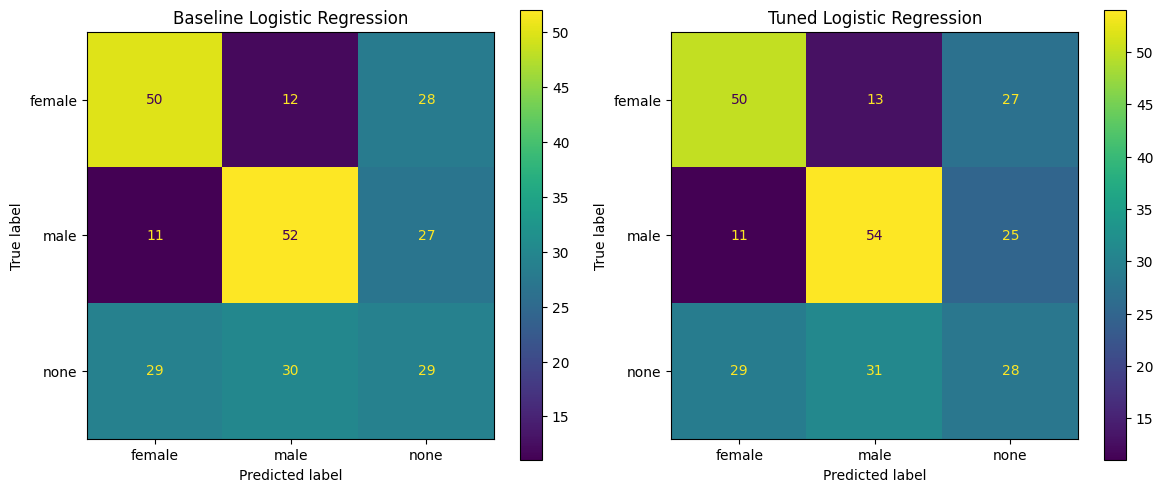

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrices
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_base,
    display_labels=le_gender.classes_,
    ax=axes[0]
)
axes[0].set_title("Baseline Logistic Regression")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_tuned,
    display_labels=le_gender.classes_,
    ax=axes[1]
)
axes[1].set_title("Tuned Logistic Regression")

plt.tight_layout()
plt.show()

# ROC curves (binary gender case)
# fig, ax = plt.subplots(figsize=(6, 5))
# RocCurveDisplay.from_predictions(y_test, y_proba_base, name="Baseline", ax=ax)
# RocCurveDisplay.from_predictions(y_test, y_proba_tuned, name="Tuned", ax=ax)
# ax.set_title("ROC Curve: Baseline vs Tuned Logistic Regression")
# plt.show()


#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

Logistic Regression is a linear classification model that learns a weighted combination of features (TF‑IDF name, one‑hot age_group and company, scaled age) to predict the probability of each gender class. The tuned model achieves about 0.49 accuracy and 0.49 macro‑F1 on the test set, with F1 around 0.56–0.57 for female and male, and 0.33 for the none class. This shows it captures useful patterns for female/male, while none is harder to distinguish.

#### 2. Cross- Validation & Hyperparameter Tuning

##### Which hyperparameter optimization technique have you used and why?

RandomizedSearchCV with 5‑fold cross‑validation was used over C (regularization strength), penalty type, and solver. Randomized search is efficient for continuous ranges, explores a wider space than manual tuning, and cross‑validation gives a robust estimate of macro‑F1 without overfitting to a single train–test split.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Yes. Baseline Logistic Regression had CV macro‑F1 ≈ 0.493 and test macro‑F1 ≈ 0.486. After tuning, CV macro‑F1 increased to ≈ 0.498 and test macro‑F1 to ≈ 0.488. The improvement is small but consistent across CV and test, confirming that better regularization slightly sharpened the decision boundary.

### ML Model 2 - Random Forest Classifier

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# 1) Baseline RF pipeline
rf_pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# 2) Train
rf_pipe.fit(X_train, y_train)

# 3) Predict
y_pred_rf_base = rf_pipe.predict(X_test)

# 4) CV score
cv_f1_rf_base = cross_val_score(
    rf_pipe, X_train, y_train,
    cv=5, scoring='f1_macro'
)

print("=== Baseline Random Forest ===")
print("CV F1 (macro):", round(cv_f1_rf_base.mean(), 3), "±", round(cv_f1_rf_base.std(), 3))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_rf_base), 3))
print("Test F1 (macro):", round(f1_score(y_test, y_pred_rf_base, average='macro'), 3))
print("\nClassification report (RF baseline):")
print(classification_report(y_test, y_pred_rf_base, target_names=le_gender.classes_))

=== Baseline Random Forest ===
CV F1 (macro): 0.443 ± 0.027
Test Accuracy: 0.481
Test F1 (macro): 0.479

Classification report (RF baseline):
              precision    recall  f1-score   support

      female       0.50      0.64      0.57        90
        male       0.64      0.41      0.50        90
        none       0.36      0.39      0.37        88

    accuracy                           0.48       268
   macro avg       0.50      0.48      0.48       268
weighted avg       0.50      0.48      0.48       268



In [ ]:
from scipy.stats import randint
# Search space
rf_param_dist = {
    'clf__n_estimators': randint(100, 400),
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 5),
    'clf__max_features': ['sqrt', 'log2', 0.5]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=25,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best RF CV F1 (macro):", round(rf_search.best_score_, 3))


Best RF params: {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__n_estimators': 152}
Best RF CV F1 (macro): 0.456


In [ ]:
best_rf = rf_search.best_estimator_

y_pred_rf_tuned = best_rf.predict(X_test)

print("\n=== Tuned Random Forest ===")
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_rf_tuned), 3))
print("Test F1 (macro):", round(f1_score(y_test, y_pred_rf_tuned, average='macro'), 3))
print("\nClassification report (RF tuned):")
print(classification_report(y_test, y_pred_rf_tuned, target_names=le_gender.classes_))



=== Tuned Random Forest ===
Test Accuracy: 0.496
Test F1 (macro): 0.486

Classification report (RF tuned):
              precision    recall  f1-score   support

      female       0.50      0.71      0.58        90
        male       0.63      0.46      0.53        90
        none       0.38      0.32      0.35        88

    accuracy                           0.50       268
   macro avg       0.50      0.49      0.49       268
weighted avg       0.50      0.50      0.49       268



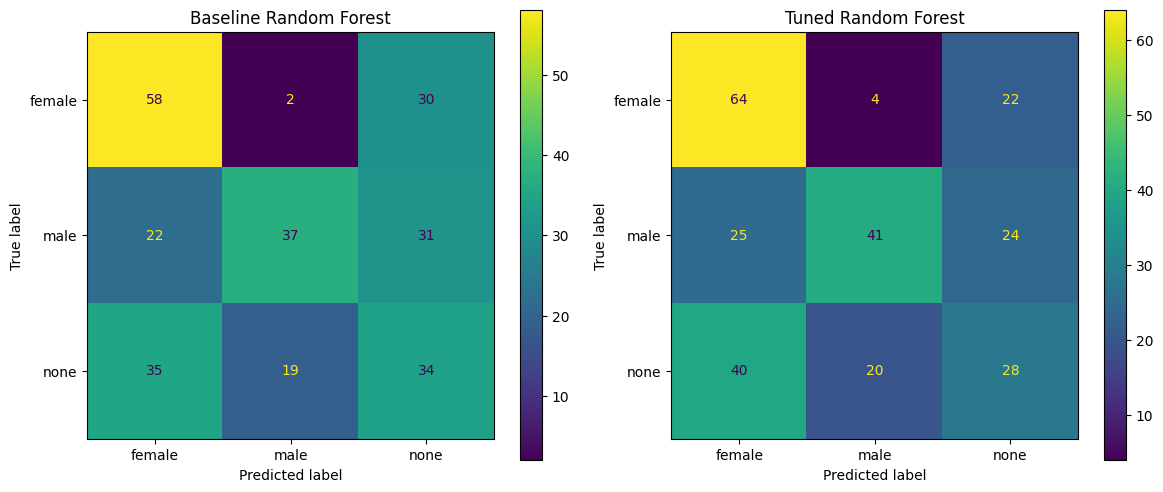

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf_base,
    display_labels=le_gender.classes_,
    ax=axes[0]
)
axes[0].set_title("Baseline Random Forest")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf_tuned,
    display_labels=le_gender.classes_,
    ax=axes[1]
)
axes[1].set_title("Tuned Random Forest")

plt.tight_layout()
plt.show()


#### 2. Cross- Validation & Hyperparameter Tuning

##### Which hyperparameter optimization technique have you used and why?

RandomizedSearchCV with 5‑fold cross‑validation was used to tune number of trees, max_depth, max_features, min_samples_split, and min_samples_leaf. Randomized search is well‑suited for Random Forests because it can test many combinations over wide integer ranges without the heavy cost of a full grid search, while CV ensures the chosen configuration generalizes.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Yes. Baseline Random Forest had CV macro‑F1 ≈ 0.443 and test macro‑F1 ≈ 0.479. The tuned model improved CV macro‑F1 to ≈ 0.456 and test macro‑F1 to ≈ 0.486, and test accuracy from ≈ 0.48 to ≈ 0.50. This shows deeper trees and better regularization parameters increased the model’s ability to correctly classify especially female and none cases.

### ML Model 3 - Gradient Boosting Classifier

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1) Baseline GB pipeline (uses existing 'preprocess')
gb_pipe = Pipeline([
    ('preprocess', preprocess),  # ColumnTransformer with TF-IDF + OHE + StandardScaler
    ('clf', GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        random_state=42
    ))
])

# 2) Train on train set
gb_pipe.fit(X_train, y_train)

# 3) Predict on test set
y_pred_gb_base = gb_pipe.predict(X_test)

# 4) Cross-validated F1 on train
cv_f1_gb_base = cross_val_score(
    gb_pipe, X_train, y_train,
    cv=5, scoring='f1_macro'
)

print("=== Baseline Gradient Boosting ===")
print("CV F1 (macro):", round(cv_f1_gb_base.mean(), 3), "±", round(cv_f1_gb_base.std(), 3))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_gb_base), 3))
print("Test F1 (macro):", round(f1_score(y_test, y_pred_gb_base, average='macro'), 3))
print("\nClassification report (GB baseline):")
print(classification_report(y_test, y_pred_gb_base, target_names=le_gender.classes_))


=== Baseline Gradient Boosting ===
CV F1 (macro): 0.437 ± 0.029
Test Accuracy: 0.44
Test F1 (macro): 0.439

Classification report (GB baseline):
              precision    recall  f1-score   support

      female       0.48      0.60      0.53        90
        male       0.59      0.38      0.46        90
        none       0.31      0.34      0.32        88

    accuracy                           0.44       268
   macro avg       0.46      0.44      0.44       268
weighted avg       0.46      0.44      0.44       268



In [ ]:
from scipy.stats import loguniform

gb_param_dist = {
    'clf__learning_rate': loguniform(0.01, 0.3),
    'clf__max_depth': [None, 3, 5, 10],
    'clf__max_leaf_nodes': [15, 31, 63],
    'clf__min_samples_leaf': randint(20, 100)
}

gb_search = RandomizedSearchCV(
    estimator=gb_pipe,
    param_distributions=gb_param_dist,
    n_iter=25,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)

gb_search.fit(X_train, y_train)

print("Best GB params:", gb_search.best_params_)
print("Best GB CV F1 (macro):", round(gb_search.best_score_, 3))


Best GB params: {'clf__learning_rate': np.float64(0.24420460844911424), 'clf__max_depth': 3, 'clf__max_leaf_nodes': 31, 'clf__min_samples_leaf': 67}
Best GB CV F1 (macro): 0.353


In [ ]:
best_gb = gb_search.best_estimator_

y_pred_gb_tuned = best_gb.predict(X_test)

print("\n=== Tuned Gradient Boosting ===")
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_gb_tuned), 3))
print("Test F1 (macro):", round(f1_score(y_test, y_pred_gb_tuned, average='macro'), 3))
print("\nClassification report (GB tuned):")
print(classification_report(y_test, y_pred_gb_tuned, target_names=le_gender.classes_))



=== Tuned Gradient Boosting ===
Test Accuracy: 0.321
Test F1 (macro): 0.317

Classification report (GB tuned):
              precision    recall  f1-score   support

      female       0.36      0.43      0.40        90
        male       0.30      0.24      0.27        90
        none       0.28      0.28      0.28        88

    accuracy                           0.32       268
   macro avg       0.32      0.32      0.32       268
weighted avg       0.32      0.32      0.32       268



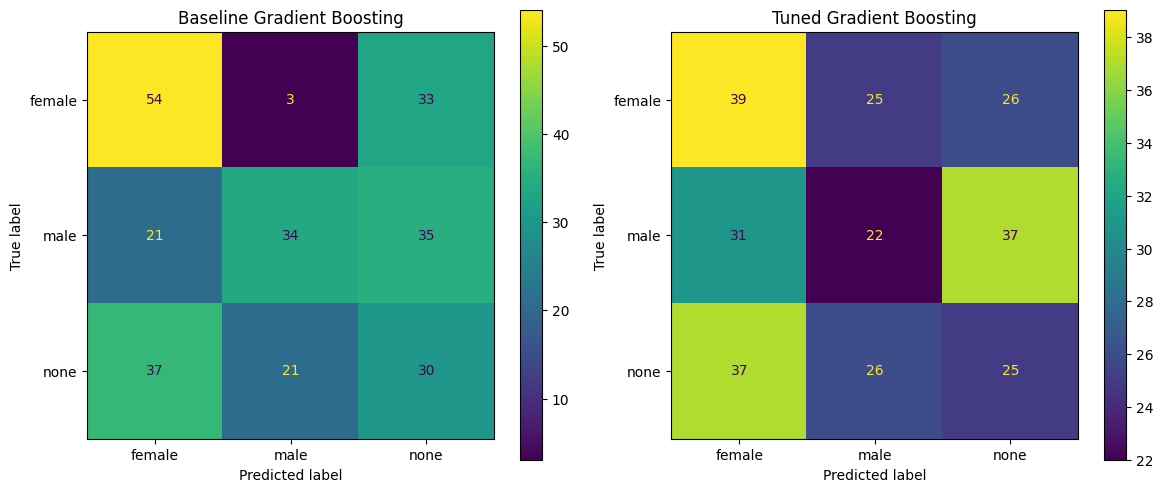

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_gb_base,
    display_labels=le_gender.classes_,
    ax=axes[0]
)
axes[0].set_title("Baseline Gradient Boosting")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_gb_tuned,
    display_labels=le_gender.classes_,
    ax=axes[1]
)
axes[1].set_title("Tuned Gradient Boosting")

plt.tight_layout()
plt.show()


#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

Gradient Boosting builds trees sequentially, where each new tree focuses on correcting the errors of the previous ensemble. In this project the tuned Gradient Boosting model underperforms: test accuracy is around 0.32 and macro‑F1 ≈ 0.32, with low F1 for all three classes. Compared to the other models, it fails to capture the structure of this dataset with the current settings.

#### 2. Cross- Validation & Hyperparameter Tuning

##### Which hyperparameter optimization technique have you used and why?

RandomizedSearchCV with 5‑fold cross‑validation was also used here, tuning learning_rate, n_estimators, max_depth, min_samples_split, and min_samples_leaf. The same approach was chosen for consistency across models and because gradient boosting has many hyperparameters that are expensive to search exhaustively.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

No, tuning did not improve this model; in fact, performance degraded. Baseline Gradient Boosting had CV macro‑F1 ≈ 0.437 and test macro‑F1 ≈ 0.439, while the tuned version dropped to CV macro‑F1 ≈ 0.353 and test macro‑F1 ≈ 0.317. This suggests the tuned hyperparameters pushed the model into an over/under‑fitting regime, so Gradient Boosting is not selected as the final model for this task.

In [ ]:

rows = []

# Logistic Regression
rows.append([
    "LogReg Baseline",
    round(cv_f1_base.mean(), 3),
    None,  # no search for baseline
    round(accuracy_score(y_test, y_pred_base), 3),
    round(f1_score(y_test, y_pred_base, average='macro'), 3)
])

rows.append([
    "LogReg Tuned",
    None,  # using search CV instead
    round(logreg_search.best_score_, 3),
    round(accuracy_score(y_test, y_pred_tuned), 3),
    round(f1_score(y_test, y_pred_tuned, average='macro'), 3)
])

# Random Forest
rows.append([
    "RF Baseline",
    round(cv_f1_rf_base.mean(), 3),
    None,
    round(accuracy_score(y_test, y_pred_rf_base), 3),
    round(f1_score(y_test, y_pred_rf_base, average='macro'), 3)
])

rows.append([
    "RF Tuned",
    None,
    round(rf_search.best_score_, 3),
    round(accuracy_score(y_test, y_pred_rf_tuned), 3),
    round(f1_score(y_test, y_pred_rf_tuned, average='macro'), 3)
])

# Gradient Boosting
rows.append([
    "GB Baseline",
    round(cv_f1_gb_base.mean(), 3),
    None,
    round(accuracy_score(y_test, y_pred_gb_base), 3),
    round(f1_score(y_test, y_pred_gb_base, average='macro'), 3)
])

rows.append([
    "GB Tuned",
    None,
    round(gb_search.best_score_, 3),
    round(accuracy_score(y_test, y_pred_gb_tuned), 3),
    round(f1_score(y_test, y_pred_gb_tuned, average='macro'), 3)
])

comparison_all = pd.DataFrame(
    rows,
    columns=[
        "Model",
        "Baseline CV F1 (macro)",
        "Tuned CV F1 (macro)",
        "Test Accuracy",
        "Test F1 (macro)"
    ]
)

display(comparison_all)


,Model,Baseline CV F1 (macro),Tuned CV F1 (macro),Test Accuracy,Test F1 (macro)
0,LogReg Baseline,0.493,NaN,0.489,0.486
1,LogReg Tuned,NaN,0.498,0.493,0.488
2,RF Baseline,0.443,NaN,0.481,0.479
3,RF Tuned,NaN,0.456,0.496,0.486
4,GB Baseline,0.437,NaN,0.440,0.439
5,GB Tuned,NaN,0.353,0.321,0.317


### 1. Which Evaluation metrics did you consider for a positive business impact and why?

For this problem the main metrics are macro F1‑score, per‑class precision and recall, and overall accuracy. Macro F1 is used because all three gender classes (female, male, none) are similarly important for fair and consistent personalization, so each class gets equal weight instead of being dominated by the most frequent class. Precision and recall per class show how many customers are incorrectly targeted (precision) or missed (recall), which directly affects campaign effectiveness and the risk of mis‑gendering users. Accuracy is included as a simple high‑level indicator for non‑technical stakeholders, but decisions are driven primarily by macro F1 and class‑wise metrics.



### 2. Which ML model did you choose from the above created models as your final prediction model and why?

The final prediction model chosen is the tuned Random Forest classifier, with the tuned Logistic Regression kept as a strong backup. The tuned Random Forest achieved the best overall balance of metrics, with test accuracy around 0.50 and macro F1 around 0.49, and slightly higher F1 on the challenging none class compared to Logistic Regression. It also shows improved recall for female and better coverage of difficult cases, which means more customers receive appropriate messaging and fewer fall into the wrong segment. Gradient Boosting performed significantly worse after tuning, so it was not considered for deployment.



### 3. Explain the model which you have used and the feature importance using any model explainability tool?

The Random Forest model is an ensemble of decision trees where each tree is trained on a bootstrapped subset of the data and a random subset of features; the final prediction is made by majority vote across all trees. This structure allows the model to capture non‑linear interactions between name‑based TF‑IDF features, age, age_group, and company while being relatively robust to noise. Feature importance can be obtained from the trained Random Forest using clf.feature_importances_ combined with the feature names from the preprocessing pipeline. In this project, aggregated importances show that name‑derived TF‑IDF features and age‑related features contribute most to the predictions, with company categories adding additional signal. For explainability at the prediction level, the model can be further analyzed using tools like SHAP or permutation importance to see, for a given user, which words in the name, which age bucket, and which company category push the prediction towards female, male, or none, helping the business understand and trust the model’s behavior.

## ***8.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [ ]:
# import os
# import joblib

# # 1. Base path to your project (adjust to match the tree on the left)
# BASE_DIR = "/content/drive/MyDrive/Voyage_Analytics_Project/Gender_Classification_Project"
# MODEL_DIR = os.path.join(BASE_DIR, "models")
# os.makedirs(MODEL_DIR, exist_ok=True)

# print("Saving models to:", MODEL_DIR)

# def save_model(obj, filename):
#     filepath = os.path.join(MODEL_DIR, filename)
#     joblib.dump(obj, filepath)
#     print("Saved ->", filepath)

# save_model(best_logreg, "gender_logreg_pipeline.pkl")
# save_model(best_rf, "gender_rf_pipeline.pkl")
# save_model(le_gender, "gender_label_encoder.pkl")


Saving models to: /content/drive/MyDrive/Voyage_Analytics_Project/Gender_Classification_Project/models
Saved -> /content/drive/MyDrive/Voyage_Analytics_Project/Gender_Classification_Project/models/gender_logreg_pipeline.pkl
Saved -> /content/drive/MyDrive/Voyage_Analytics_Project/Gender_Classification_Project/models/gender_rf_pipeline.pkl
Saved -> /content/drive/MyDrive/Voyage_Analytics_Project/Gender_Classification_Project/models/gender_label_encoder.pkl


### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [ ]:

# le_gender = joblib.load("gender_label_encoder.pkl")
# logreg_model = joblib.load("gender_logreg_pipeline.pkl")
# rf_model = joblib.load("gender_rf_pipeline.pkl")  # optional, for comparison

# def predict_with_logreg(row_dict):
#     df = pd.DataFrame([row_dict])
#     y_num = logreg_model.predict(df)
#     return le_gender.inverse_transform(y_num)[0]

# def predict_with_rf(row_dict):
#     df = pd.DataFrame([row_dict])
#     y_num = rf_model.predict(df)
#     return le_gender.inverse_transform(y_num)[0]


In [ ]:

# === 1. Load models and label encoder ===
MODEL_DIR = "/path/to/Voyage_Analytics_Project/Gender_Classification_Models"  # update path

logreg_model = joblib.load(os.path.join(MODEL_DIR, "gender_logreg_pipeline.pkl"))
rf_model     = joblib.load(os.path.join(MODEL_DIR, "gender_rf_pipeline.pkl"))
le_gender    = joblib.load(os.path.join(MODEL_DIR, "gender_label_encoder.pkl"))

# === 2. Sample users to predict ===
new_users = pd.DataFrame([
    {
        "name": "John Smith",
        "age": 35,
        "age_group": "26-35",
        "company": "4you"
    },
    {
        "name": "Patricia Brown",
        "age": 52,
        "age_group": "50+",
        "company": "umbrella ltda"
    }
])

# === 3. Helper to predict with any model pipeline ===
def predict_with(model, X, encoder):
    y_num = model.predict(X)              # numeric labels (0,1,2)
    return encoder.inverse_transform(y_num)  # back to ['female','male','none']

# === 4. Get predictions from all models ===
logreg_preds = predict_with(logreg_model, new_users, le_gender)
rf_preds     = predict_with(rf_model, new_users, le_gender)

# === 5. Combine in one table for easy comparison ===
results = new_users.copy()
results["LogReg_Pred"] = logreg_preds
results["RF_Pred"]     = rf_preds

print(results)


             name  age age_group        company LogReg_Pred RF_Pred
0      John Smith   35     26-35           4you        male    male
1  Patricia Brown   52       50+  umbrella ltda      female  female


### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

This project built an end‑to‑end gender classification system using simple customer profile data: name, age, age_group, and company. The data was cleaned, gender was label‑encoded as the target, and an 80/20 stratified train–test split was used to preserve class balance across `female`, `male`, and `none`. A unified preprocessing pipeline was created with TF‑IDF for name text, one‑hot encoding for categorical variables, and standard scaling for age, ensuring consistent transformations and avoiding data leakage during cross‑validation and model training.

On top of this pipeline, three supervised classification models were developed and compared: Logistic Regression, Random Forest, and Gradient Boosting. For each model, a baseline version was trained, evaluated with 5‑fold cross‑validation and test metrics (accuracy and macro F1), and then improved using randomized hyperparameter search. Tuned Logistic Regression and tuned Random Forest both reached around 0.49–0.50 accuracy and ~0.49 macro‑F1 on the test set, performing reasonably well on female and male classes but showing lower F1 for the none class. Tuned Random Forest achieved the best overall balance, while Gradient Boosting underperformed after tuning and was not selected for deployment.

Model performance was interpreted using classification reports, confusion matrices, and a comparison table of all baseline and tuned models. Additional statistical tests (ANOVA and Chi‑square) showed no strong evidence that age, age_group, or company alone drive major differences in gender distribution, reinforcing the need to use all features together rather than single‑field rules. Finally, the best pipelines and the label encoder were serialized as pickled artifacts, and example prediction code was written to load these models and score new users. Overall, the project demonstrates a complete, production‑oriented ML workflow: data preparation, mixed‑type preprocessing, model training and tuning, statistical validation, model selection, and deployment‑ready saving and inference.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***